In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import CorrelatedReadoutError
from qiskit.result import CorrelatedReadoutMitigator
from qiskit_aer import AerSimulator

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import BackendSampler

/var/folders/90/k9tnl6dj03x59gg2bh329f_00000gn/T/ipykernel_40060/3245929106.py:8: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [4]:
# Run only once to save the account
# IBMProvider.save_account(token='27fc81cc1143099c58b23780dbcb4725f2393a6016b59258fece524e61c35934cfac5f04ca7d1253750225e775c3cc1df4fd115bd23f4632961569d497648186', overwrite=True)

In [5]:
# Connect to the IBM's Quantum backend
provider = IBMProvider()
backend = provider.get_backend('ibm_sherbrooke')
sampler = BackendSampler(backend)

In [6]:
# Set up a local simulator that mimics the real backend
# service = QiskitRuntimeService()
# real_backend = service.backend("ibm_sherbrooke")
# sampler = AerSimulator.from_backend(real_backend)

In [7]:
# check for active account
provider.active_account()

{'channel': 'ibm_quantum',
 'token': '27fc81cc1143099c58b23780dbcb4725f2393a6016b59258fece524e61c35934cfac5f04ca7d1253750225e775c3cc1df4fd115bd23f4632961569d497648186',
 'url': 'https://auth.quantum-computing.ibm.com/api',
 'verify': True,
 'instance': 'ibm-q/open/main'}

MITIGATION EXPERIMENT SETUP

In [8]:
# Set up the mitigation experiment
qubits = [0,1,2]
num_qubits = len(qubits)
exp1 = CorrelatedReadoutError(qubits)

# Print mitigation experiment circuits
for c in exp1.circuits():
    print(c)

         ░ ┌─┐      
   q_0: ─░─┤M├──────
         ░ └╥┘┌─┐   
   q_1: ─░──╫─┤M├───
         ░  ║ └╥┘┌─┐
   q_2: ─░──╫──╫─┤M├
         ░  ║  ║ └╥┘
meas: 3/════╩══╩══╩═
            0  1  2 
        ┌───┐ ░ ┌─┐      
   q_0: ┤ X ├─░─┤M├──────
        └───┘ ░ └╥┘┌─┐   
   q_1: ──────░──╫─┤M├───
              ░  ║ └╥┘┌─┐
   q_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 
              ░ ┌─┐      
   q_0: ──────░─┤M├──────
        ┌───┐ ░ └╥┘┌─┐   
   q_1: ┤ X ├─░──╫─┤M├───
        └───┘ ░  ║ └╥┘┌─┐
   q_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 
        ┌───┐ ░ ┌─┐      
   q_0: ┤ X ├─░─┤M├──────
        ├───┤ ░ └╥┘┌─┐   
   q_1: ┤ X ├─░──╫─┤M├───
        └───┘ ░  ║ └╥┘┌─┐
   q_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 
              ░ ┌─┐      
   q_0: ──────░─┤M├──────
              ░ └╥┘┌─┐   
   q_1: ──────░──╫─┤M├───
     

MZI EXPERIMENT SETUP


In [9]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter

In [10]:
# Define constants & parameters
pi = np.pi
phi_R = Parameter('phi_R')
phi_S = Parameter('phi_S')

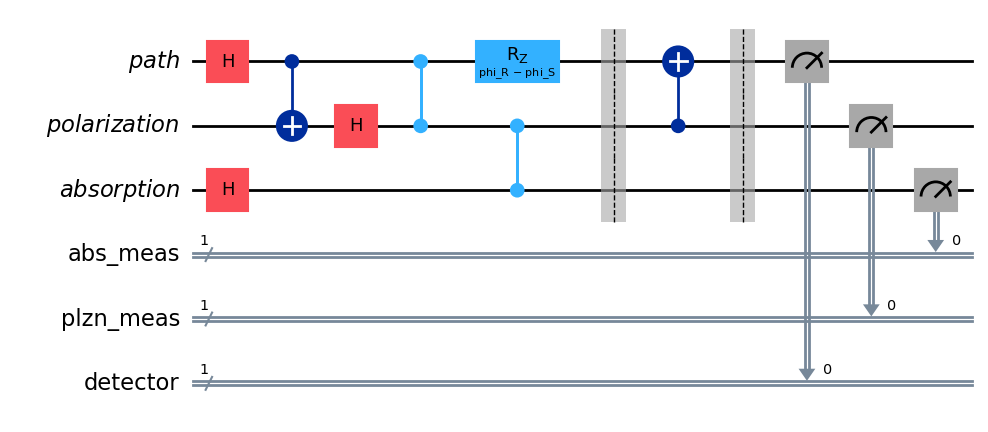

In [11]:
# Create quantum registers & classical bits
qr_photon = QuantumRegister(1, 'path')
qr_polarize = QuantumRegister(1, 'polarization')
qr_absorb= QuantumRegister(1, 'absorption')
cr_detect = ClassicalRegister(1, 'abs_meas')
cr_polarizatoin = ClassicalRegister(1, 'plzn_meas')
cr_detector = ClassicalRegister(1, 'detector')

# Create a quantum circuit 
qc = QuantumCircuit(qr_photon, qr_polarize, qr_absorb, cr_detect, cr_polarizatoin, cr_detector)

# Polarization BS, creates a superposition and an entanglement with the polarization qubit
qc.h(0)
qc.cx(0,1)

# Polarizer on each path
qc.h(1)
qc.cz(0,1)
qc.h(2)
qc.cz(2,1)

# Phase shifts by (φ_S - φ_R) due to the lengths
qc.rz(phi_R-phi_S,0)
qc.barrier()

# 2nd BS
qc.cx(1,0)

# Measurement 
qc.barrier()
qc.measure([0,1,2],[2,1,0])

# Draw & save the circuit
circuit_image = qc.draw('mpl')
circuit_image.savefig("8.Double_PBS+Polarizer_on_Both_Paths_circuit.png", dpi=300)
qc.draw('mpl')

In [12]:
# Transpile the circuit
initial_layout = {qc.qubits[0]: 39, qc.qubits[1]: 40, qc.qubits[2]: 41}
qc_trans = transpile(qc, backend, initial_layout=initial_layout)

COMBINE CIRCUITS

In [13]:
# Define # of shots for mitigation/qc runs
shots = 8192 # 2^13

In [14]:
bound_qc = [] 
exp1_qc = []

# Add the mitigation exp circuits in the list prior to the MZI circuits
for i in range(2**num_qubits):
    initial_layout1 = {exp1.circuits()[i].qubits[0]: 39, exp1.circuits()[i].qubits[1]: 40, exp1.circuits()[i].qubits[2]: 41}
    trans_exp1_qc = transpile(exp1.circuits()[i], backend, initial_layout=initial_layout1)
    exp1_qc.append(trans_exp1_qc)

# Assign phase shift params from 0 to 2π & add the MZI circuits in the list
for i in range(4):
    param_values = {phi_S: 0, phi_R: (pi/2)*i}
    bound_qc.append(qc_trans.assign_parameters(param_values))

# Combine all the circuits
all_qc = exp1_qc + bound_qc 
print(len(all_qc)) # Should be 12 in total = 8 prior mitigation circ + 4 MZI circ (0, pi/2, pi, 2pi)

12


RUN THE EXPERIMENT

In [15]:
# Run on the real backend 
# job = sampler.run(all_qc, shots=shots)
# print(job.job_id())

RETRIEVE THE JOB

In [16]:
# Define job id & retreive the job
job_id = 'cte6rntxgmhg0084ry5g'
job = QiskitRuntimeService().job(job_id)
result = job.result()

In [17]:
# Get Mitigation experitment results
exp_results = [result.get_counts()[i] for i in range(2**num_qubits)]

# Takes in mitigation experiment results and contructs a assignment matrix
# Returns an assignment matrix
def generate_assignment_matrix(exp_results):
    state_labels = ['000','001', '010', '011', '100', '101', '110', '111']
    assignment_matrix = np.zeros((2**num_qubits, 2**num_qubits))
    for state_idx, state in enumerate(state_labels):
        counts = exp_results[state_idx]
        for measured_state, count in counts.items():
            measured_idx = state_labels.index(measured_state)
            assignment_matrix[measured_idx, state_idx] = count / shots
    return assignment_matrix

# Construct mitigator objects
mitigator = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp_results))

# Get unmitigated counts
unmitigated_counts_raw = [result.get_counts()[2**num_qubits+i] for i in range(len(bound_qc))]
unmitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_counts_raw]

SAVE DATA AS A CSV FILE

In [18]:
import pandas as pd

# Convert the counts to a pandas DataFrame
exp_df = pd.DataFrame(exp_results)
counts_df = pd.DataFrame(unmitigated_counts)

# Add a column for the circuit number
exp_df['Circuit Number'] = range(1, len(exp_df) + 1)
counts_df['Circuit Number'] = range(1, len(counts_df) + 1)

# Reorder the columns so that 'Circuit Number' comes first
exp_df = exp_df[['Circuit Number', '000', '001', '010', '011', '100', '101', '110', '111']]
counts_df = counts_df[['Circuit Number', '0 0 0', '0 0 1', '0 1 0', '0 1 1', '1 0 0', '1 0 1', '1 1 0', '1 1 1']]

# Save the DataFrame to a CSV file
exp_df.to_csv('8.pre_mitigation_circ_count.csv', index=False)
counts_df.to_csv('8.MZI_circ_counts.csv', index=False)

DEFINE TWO MITIGATION METHODS

In [21]:
# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator)  
# Calculates unmitigated probailities, mitigated quasi-probabilities
# Calculates mitigated probabilities with quasi-probabilites on L2 norm
# Calculates mitigated counts
def mitigation_method_1(mitigator):
    unmitigated_probs, mitigated_quasi_probs, mitigated_probs, mitigated_counts = [], [], [], []
    for i in range(len(bound_qc)):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        mitigated_quasi_probs.append(mitigator.quasi_probabilities(unmitigated_counts[i]))
        mitigated_probs.append(mitigated_quasi_probs[i].nearest_probability_distribution().binary_probabilities())
        mitigated_counts.append({label: round(prob*shots) for (label, prob) in mitigated_probs[i].items()})
    fixed_unmitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_probs]
    fixed_mitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_probs]
    fixed_mitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_counts]
    return fixed_unmitigated_probs, fixed_mitigated_probs, fixed_mitigated_counts


# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator) 
# Calculates unmitigated probailities
# Calculates mitigated quasi-counts by multiplication with inv confusion matrix
# Calculates mitigated counts by throwing away negative counts
# Calculates mitigated probabilites by re-normalizing with new shots #
def mitigation_method_2(mitigator):
    unmitigated_probs, mitigated_probs, mitigated_counts = [], [], []
    for i in range(len(bound_qc)):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        # Creates a column vector of the counts
        vec_count = np.array([unmitigated_counts[i]['0 0 0'], unmitigated_counts[i]['0 0 1'], unmitigated_counts[i]['0 1 0'], unmitigated_counts[i]['0 1 1'], 
                              unmitigated_counts[i]['1 0 0'], unmitigated_counts[i]['1 0 1'], unmitigated_counts[i]['1 1 0'], unmitigated_counts[i]['1 1 1']])[:, np.newaxis]
        mitigated_quasi_count = np.dot(mitigator.mitigation_matrix(),vec_count)
        # if either count is negative, set it to 0 and calculate the total count
        total_count = 0
        for i in range(len(vec_count)):
            if mitigated_quasi_count[i] < 0:mitigated_quasi_count[i] = 0
            total_count += mitigated_quasi_count[i]
        # Define dictionaries
        dict_count = {
            '000': mitigated_quasi_count[0].item(),
            '001': mitigated_quasi_count[1].item(),
            '010': mitigated_quasi_count[2].item(),
            '011': mitigated_quasi_count[3].item(),
            '100': mitigated_quasi_count[4].item(),
            '101': mitigated_quasi_count[5].item(),
            '110': mitigated_quasi_count[6].item(),
            '111': mitigated_quasi_count[7].item()
        }
        dict_prob = {
            '000': (mitigated_quasi_count[0]/total_count).item(),
            '001': (mitigated_quasi_count[1]/total_count).item(),
            '010': (mitigated_quasi_count[2]/total_count).item(),
            '011': (mitigated_quasi_count[3]/total_count).item(),
            '100': (mitigated_quasi_count[4]/total_count).item(),
            '101': (mitigated_quasi_count[5]/total_count).item(),
            '110': (mitigated_quasi_count[6]/total_count).item(),
            '111': (mitigated_quasi_count[7]/total_count).item()
        }
        mitigated_counts.append(dict_count)
        mitigated_probs.append(dict_prob)
    fixed_unmitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_probs]
    fixed_mitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_probs]
    fixed_mitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_counts]
    return fixed_unmitigated_probs, fixed_mitigated_probs, fixed_mitigated_counts  

PRINT RESULT

Unmitigated Counts: 
{'0 0 1': 1135, '0 0 0': 1039, '1 0 1': 1214, '0 1 1': 1049, '1 1 1': 940, '0 1 0': 872, '1 0 0': 1138, '1 1 0': 805}
Mitigated Counts: 
{'011': 814, '010': 870, '111': 948, '000': 1027, '110': 1051, '100': 1120, '001': 1147, '101': 1215}

Unmitigated Prob: 
{'1 0 0': 0.1385498046875, '0 0 0': 0.1268310546875, '1 0 1': 0.148193359375, '1 1 0': 0.1280517578125, '1 1 1': 0.11474609375, '0 1 0': 0.1064453125, '0 0 1': 0.138916015625, '0 1 1': 0.0982666015625}
Mitigated Prob: 
{'011': 0.09931712502993412, '010': 0.10620414612055225, '111': 0.11577138774278178, '000': 0.12532637644898295, '110': 0.1283395500374153, '100': 0.1367656004260787, '001': 0.13999887539185737, '101': 0.14827693880239767}


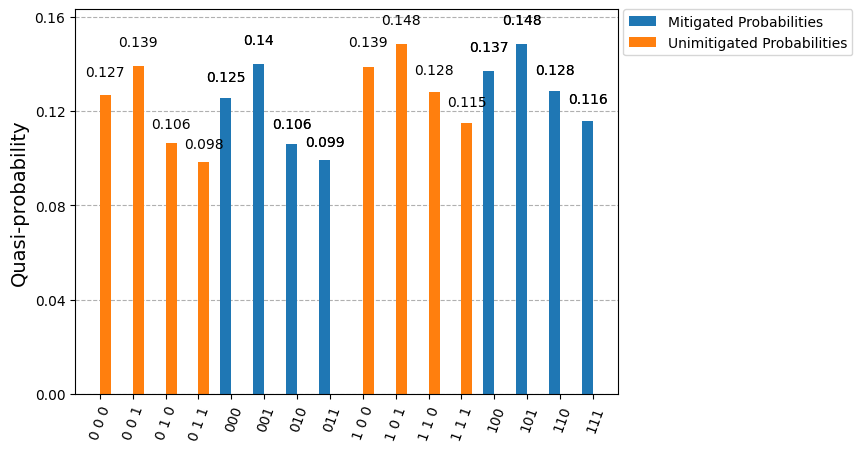

In [22]:
# Pick a mitigation_method (method_1 = least_squares, method_2 = throwaway zeros)
# Parameter: 0 for pre-mitigator, 1 for post-mitigator
unmitigated_probs, mitigated_probs, mitigated_counts = mitigation_method_1(mitigator)

# Index of a circuit [0:0π 1=π/2, 2=π, 3=3π/2]
i = 0

# Print unmitigated & mitigated counts and plot 

print("Unmitigated Counts: ")
print(unmitigated_counts[i]) 
print("Mitigated Counts: ")
print(mitigated_counts[i])
print("")
print("Unmitigated Prob: ")
print(unmitigated_probs[i])
print("Mitigated Prob: ")
print(mitigated_probs[i])

legend = ['Mitigated Probabilities','Unimitigated Probabilities']
plot_distribution([mitigated_probs[i], unmitigated_probs[i]], legend=legend)

SCATTER PLOT OVER ALL ANGLES

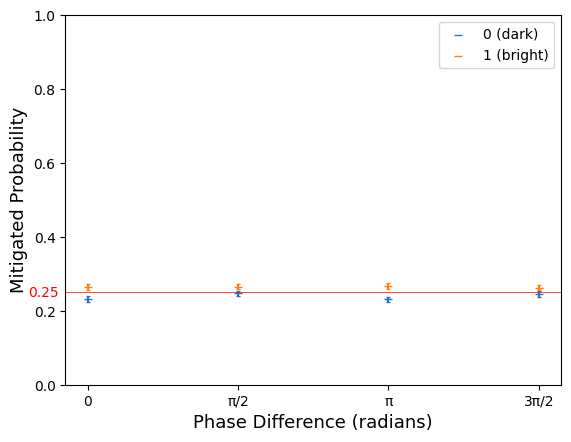

In [27]:
# Extract x, y data 
x = [(pi/2)*i for i in range(len(mitigated_probs))]
y_0 = [(d.get('000', 0) + d.get('010', 0)) for d in mitigated_probs]
y_1 = [(d.get('110', 0) + d.get('100', 0)) for d in mitigated_probs]

# Calculate standard error (SE = sqrt(p(1-p)/n)) measures how much the probability varies from the true probability.
y_err = [np.sqrt(y_0[i] * y_1[i]/(mitigated_counts[i].get('000',0) + mitigated_counts[i].get('010',0) + mitigated_counts[i].get('110',0) + mitigated_counts[i].get('100',0)))*1.96 for i in range (len(mitigated_probs))]


# Create a scatter a scatter plot
plt.errorbar(x, y_0, yerr=y_err, capsize=1.7, linestyle='none')
plt.errorbar(x, y_1, yerr=y_err, capsize=1.7, linestyle='none')
plt.scatter(x,y_0, label='0 (dark)', marker="_", linewidths=1)
plt.scatter(x,y_1, label='1 (bright)', marker="_", linewidths=1)

plt.axhline(y=0.25, color='red', linestyle='-', linewidth=0.5)
plt.text(-0.3, 0.25, '0.25', color='red', va='center', ha='right')

plt.xlabel('Phase Difference (radians)', size = 13)
tick_positions = [(pi/2)*i for i in range(4)]
tick_labels = ['0', 'π/2' , 'π', '3π/2']
plt.xticks(tick_positions, tick_labels)
plt.ylim(0,1)
plt.ylabel('Mitigated Probability', size = 13)
plt.legend()
plt.savefig("8.Double_PBS+Polarizer_on_Both_Paths_result.png", dpi=300)